## Kannada MNIST Digits Dataset

This notebook is my second iteration of the Kannada MNIST dataset I found on Kaggle. I decided to start from scratch because I wanted to try using a CNN and implementing data augmentation. 

My previous attempt resulted in accuracy scores in the 90%s on the validation set; however, I received accuracy scores in the 60%s on the holdout set. This made me think that I either didn't have enough data to train on, or the data in the holdout set wasn't an accuracte representation of the training data. My previous notebook compared neural network of just Dense layers (2x50, 2x100, 3x50, and 3x100).

Since this is a dataset on digits, I think I will be able to improve accuracy scores by using a CNN and augmenting the data through rotations, shearing, etc.

## Importing and Reshaping Data

In [1]:
# Import Packages
import pandas as pd
import numpy as np
from keras.utils import to_categorical, np_utils
from sklearn.utils import shuffle
from keras import regularizers

Using TensorFlow backend.


In [2]:
# Import Data
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Convert features and target into arrays
y = df['label'].values
X = df.loc[:,df.columns != 'label'].values
X = np.true_divide(X, 255)

# Make n_cols variable to use in model parameters
n_cols = X.shape[1]

In [4]:
# Split data into train and test
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 56)

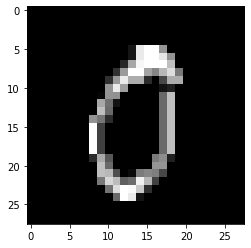

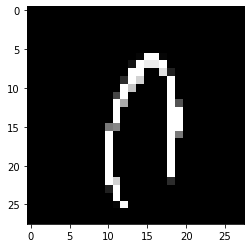

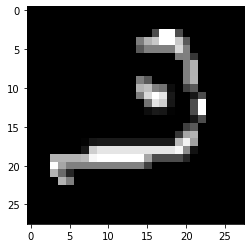

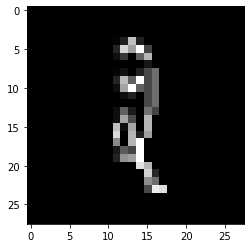

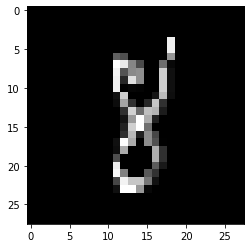

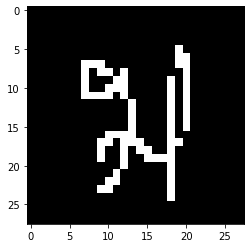

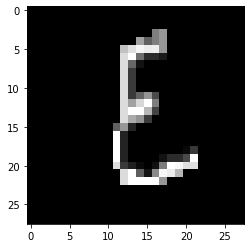

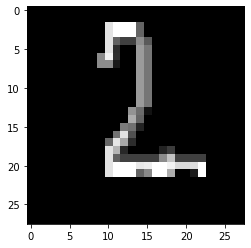

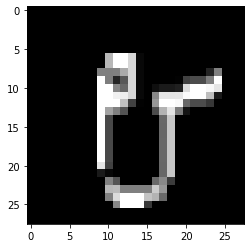

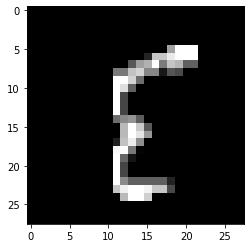

In [5]:
# Show first 10 images
%matplotlib inline 
from matplotlib import pyplot as plt

for i in range(10):
    image = np.reshape(X[i], (28,28))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

In [6]:
# Create 4d tensors
Xtrain = Xtrain.reshape(-1, 28, 28, 1) # TensorFlow read -1 as n
Xtest = Xtest.reshape(-1, 28, 28, 1)   # TensorFlow read -1 as n
print(Xtrain.shape)
print(Xtest.shape)

ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)
print(ytrain.shape)
print(ytest.shape)

# Create input shape variable for parameters in the model
image_rows = 28
image_cols = 28
colors = 1
input_shape = (image_rows, image_cols, colors)

(42000, 28, 28, 1)
(18000, 28, 28, 1)
(42000, 10)
(18000, 10)


## Creating the CNN

In [7]:
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential 

def getModel():
    # Instantiate the model
    model = Sequential()

    # Conv2D takes n dimensional image and makes it 2d
    # Filter parameter recommended using powers of 2
    # Kernel_size parameter is (1,1) a tuple of odd integers. Recommneded is 1,3,5,7
    # Strides parameter is default (1,1) 
    # Padding parameter is "valid" or "same". "valid" means spatial dimensions are allowed to reduce. You can instead preserve spatial dimensions of the volume such that the output volume size matches the input volume size, by setting the value to “same”. 
    # Activation parameter is the activation function. Normally use "relu" to map negative values to 0
    model.add(Conv2D(4, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,
                 padding = 'same'))
    
    # Pooling layer reduces dimensionality of the feature maps but keeps the most important information
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # It seems common to increase by a power of 2 filters each Conv2d layers, if max pooling occurs directly after 
    model.add(Conv2D(8, kernel_size=(3, 3), 
                     activation='relu',
                     padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten layer takes the 2d image from Conv2d and makes it 1d array
    model.add(Dropout(0.25))
    model.add(Flatten())

    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(10, activation = 'softmax'))
    
    # Compile
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [8]:
# Fit the model
from keras.callbacks import EarlyStopping

model_original = getModel()

# Create early stopping parameter
# es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience = 10)
# Early stopping isn't really necessary since I am only using 10 epochs

history_original = model_original.fit(Xtrain, ytrain,
                                     epochs = 20,
                                     verbose = 0,
                                     #callbacks = [es],
                                     validation_data  = (Xtest, ytest),
                                     batch_size = 32)

## Augmenting Data with ImageDataGenerator()

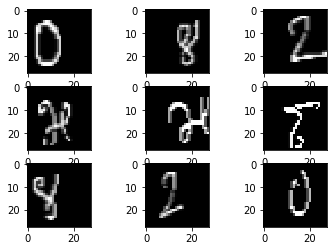

In [9]:
# Observe how parameters affect images
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=.2)
# fit parameters from data
datagen.fit(Xtrain)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(Xtrain, ytrain, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

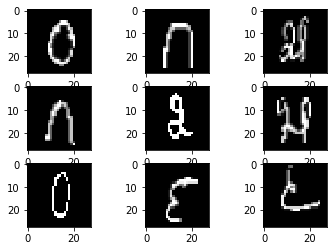

In [10]:
datagen = ImageDataGenerator(samplewise_center=True)
# fit parameters from data
datagen.fit(Xtrain)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(Xtrain, ytrain, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

C:\Users\thomas.m.sugg\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


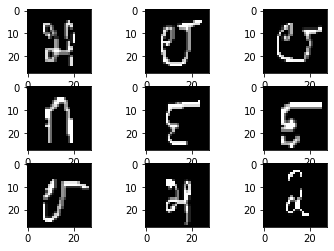

In [11]:
datagen = ImageDataGenerator(featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(Xtrain)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(Xtrain, ytrain, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

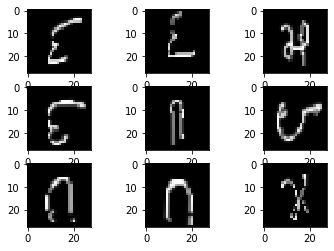

In [12]:
datagen = ImageDataGenerator(rotation_range=1.5)
# fit parameters from data
datagen.fit(Xtrain)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(Xtrain, ytrain, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [13]:
# Data Augmentation
# Create copies of the original dataset
Xtrain2 = np.array(Xtrain, copy=True)
ytrain2 = np.array(ytrain, copy=True)

# Create the image generator 
datagen1 = ImageDataGenerator(width_shift_range= 0.2, #Horizontal shift
                             fill_mode = 'nearest',
                             height_shift_range=0.2, # Vertical shift
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             rotation_range=25, # Random Rotations 
                             )

# Fit the image generator to the training data
datagen1.fit(Xtrain)

# Concatenate original data with augmented data
Xaug = np.concatenate((Xtrain, Xtrain2), axis = 0)
yaug = np.concatenate((ytrain, ytrain2), axis = 0)

print(Xtrain.shape)
print(Xtrain2.shape)
print(Xtest.shape)
print(Xaug.shape)

(42000, 28, 28, 1)
(42000, 28, 28, 1)
(18000, 28, 28, 1)
(84000, 28, 28, 1)


In [14]:
print(ytrain.shape)
print(ytrain2.shape)
print(ytest.shape)
print(yaug.shape)

(42000, 10)
(42000, 10)
(18000, 10)
(84000, 10)


## Training a Second CNN with the Generator

In [15]:
# Train with generator 
datagen_flow = datagen1.flow(Xaug, yaug, 
                            batch_size = 32)

model2 = getModel()

history_datagen = model2.fit_generator(datagen_flow, 
                                              steps_per_epoch = len(Xaug) // 32,
                                              epochs = 20, 
                                              verbose = 0,
                                              #callbacks = [es],
                                              validation_data = (Xtest, ytest))

# Evaluating Scores

In [16]:
# Print Xtest scores
print("Final non_augmented validation loss:" , history_original.history['val_loss'][-1],  "\nfinal non_augmented validation accuracy:", history_original.history['val_accuracy'][-1])
print("Final augmented validation loss: ", history_datagen.history['val_loss'][-1], "\nfinal augmented validation accuracy:", history_datagen.history['val_accuracy'][-1]) 

Final non_augmented validation loss: 0.019426436877566934 
final non_augmented validation accuracy: 0.9944999814033508
Final augmented validation loss:  0.04878174902291762 
final augmented validation accuracy: 0.9851666688919067


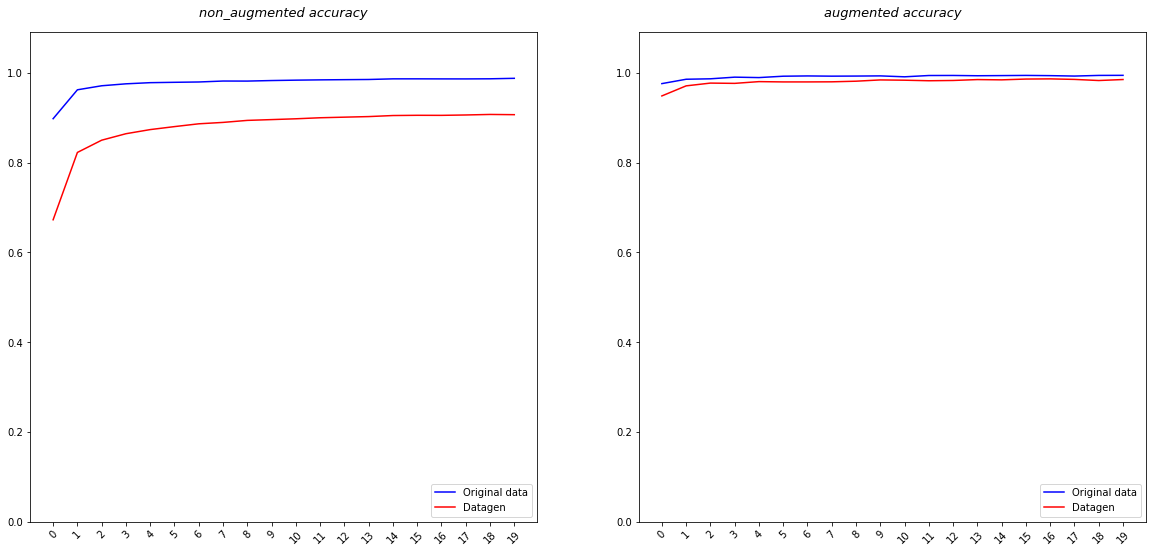

In [22]:
figure = plt.figure(figsize=(20,9))
 
subplot = figure.add_subplot(1, 2, 1)
 
plt.plot(history_original.history['accuracy'], color='blue', label='Original data')
plt.plot(history_datagen.history['accuracy'], color='red', label='Datagen')
plt.ylim(0.0,1.09)

number_of_epochs = 20
tick_marks = np.arange(number_of_epochs)
plt.xticks(tick_marks, range(number_of_epochs), rotation=45)
plt.title("non_augmented accuracy", fontsize=13, 
             fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc='lower right')
 

subplot = figure.add_subplot(1, 2, 2)
plt.plot(history_original.history['val_accuracy'], color='blue', label='Original data')
plt.plot(history_datagen.history['val_accuracy'], color='red', label='Datagen')
plt.ylim(0.0,1.09)
 
tick_marks = np.arange(number_of_epochs)
plt.xticks(tick_marks, range(number_of_epochs), rotation=45)
plt.title("augmented accuracy", fontsize=13, 
             fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc='lower right')
 
plt.show()

# Compare Scores on the Holdout Dataset

In [18]:
# Import Holdout Dataset
holdout = pd.read_csv('Dig-MNIST.csv')

# Convert features and target into arrays
holdout_label = holdout['label'].values
holdout_target = to_categorical(holdout_label)
holdout_features = holdout.loc[:,holdout.columns != 'label'].values
holdout_features = np.true_divide(holdout_features, 255)
holdout_features = holdout_features.reshape(-1,28,28,1)
print(holdout_features.shape)
print(holdout_label.shape)
print(holdout_target.shape)

(10240, 28, 28, 1)
(10240,)
(10240, 10)


## With Data Augmentation

In [19]:
# Predict accuracy on the whole holdout dataset using the different models 
from sklearn.metrics import accuracy_score

holdout_y_pred = model2.predict_classes(holdout_features)

print(holdout_y_pred)
print(holdout_target.shape)
print(holdout_y_pred.shape)

holdout_y_pred_cats = to_categorical(holdout_y_pred)
print(holdout_y_pred_cats.shape)

print("Accuracy Score:", accuracy_score(holdout_target, holdout_y_pred_cats))

[0 1 2 ... 7 2 9]
(10240, 10)
(10240,)
(10240, 10)
0.79306640625


## Without Data Augmentation 

In [20]:
y_pred = model_original.predict_classes(holdout_features)

print(y_pred)
print(holdout_target.shape)
print(y_pred.shape)

y_pred_cats = to_categorical(y_pred)
print(y_pred_cats.shape)

print("Accuracy Score:", accuracy_score(holdout_target, y_pred_cats))

[0 1 2 ... 7 8 9]
(10240, 10)
(10240,)
(10240, 10)
0.75771484375


## Results

By using a CNN, I was able to bring up the accuracy at least 15%. Data augmentation improved the CNN accuracy by about 4%.